In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle

import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score


2025-02-06 08:29:02.400102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 08:29:02.424099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738855742.446005   28995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738855742.454412   28995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 08:29:02.489861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

### Load PPE

In [3]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')
n_params = np.shape(params)[1]

In [4]:
dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_pftmean_1985-2023.nc')

In [5]:
# drop crashers
ds_clean = ds.where(ds['crashed'] != 1, drop=True)
ix = np.where(ds.crashed==1)[0]
params_clean = params.drop(ix-1)

In [6]:
# dates to match CLM-SP (per Peter Lawrence). 
lai = ds_clean.TLAI_pft_mean.sel(year=slice(2003,2015)).mean(dim='year').compute()

### Observational data

In [7]:
# CLM-SP with new surface dataset 
# uncertainty +- 30%
filename = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/BNF_v2.n01_ctsm5.3.012_transient_SP_0.clm2.h1.2000-02-01-00000.nc'
ds_sp = xr.open_dataset(filename)

yr0=str(ds_sp['time.year'][0].values)
nt=len(ds_sp.time)
ds_sp['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug

In [8]:
# take PFT mean 
yr1=2003; yr2=2015
pft=ds_sp.pfts1d_itype_veg
la=xr.open_dataset(utils_path+'lapft_ctsm5.3.012.nc')
la_pft = la.lafg.sel(year=slice(yr1,yr2)).mean(dim='year')
la_pft = la_pft.rename({"pftfg": "pft"})
la_pft = la_pft.assign_coords(pft=pft)

x=amax(ds_sp['TLAI']).mean(dim='year')
clmsp_laimax = pmean(x,la_pft)

In [9]:
# back calculate stdev from +- 30%
min = clmsp_laimax*0.7
max = clmsp_laimax*1.3
stdev = (max-min)/6

In [88]:
# observational target and range dataset for HM
obs_data = xr.Dataset(
    { "Mean": (["pft"], clmsp_laimax.values),
      "StDev": (["pft"], stdev.values),
    },
    coords={"pft": clmsp_laimax.pft},
)
obs_data.to_netcdf('CLMSP_amaxLAI_2003-2015_pftmean.nc')

### Plot

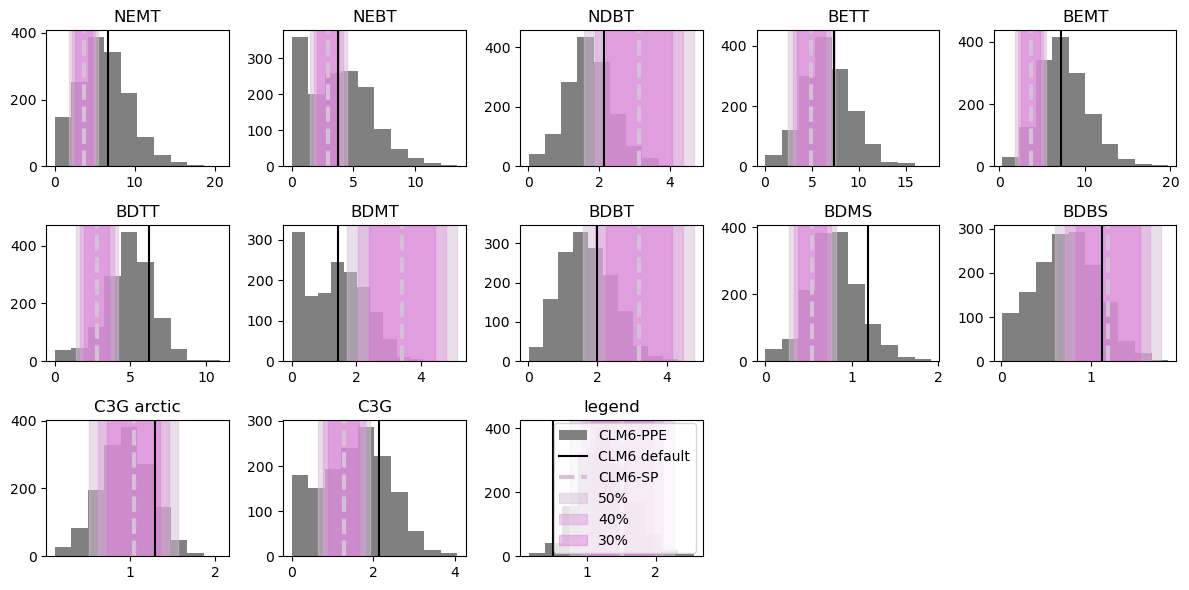

In [192]:
pft_names = ['not veg','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3G arctic','C3G','C4G']
plt.figure(figsize=(12,6))
i = 1
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14,9]
for pft in pft_ids:
    if i==14:
        plt.legend(facecolor='white',frameon=True)
        plt.title('legend')
    else:
        plt.subplot(3,5,i)
        plt.hist(lai.sel(pft=pft),color='grey',label='CLM6-PPE')
        plt.axvline(lai.sel(pft=pft,ens=0),color='k',label='CLM6 default')
        plt.axvline(obs_data['Mean'].sel(pft=pft),color='thistle',linestyle='--',linewidth=3,label='CLM6-SP')
        #plt.axvspan(obs_data['Mean'].sel(pft=pft)-3*obs_data['StDev'].sel(pft=pft),obs_data['Mean'].sel(pft=pft)+3*obs_data['StDev'].sel(pft=pft),color='thistle',alpha=0.5)
        mn = obs_data['Mean'].sel(pft=pft)
        plt.axvspan(0.5*mn,1.5*mn,color='thistle',alpha=0.5,label='50%')
        plt.axvspan(0.6*mn,1.4*mn,color='plum',alpha=0.5,label='40%')
        plt.axvspan(0.7*mn,1.3*mn,color='orchid',alpha=0.4,label='30%')
        plt.title(pft_names[pft])

    i = i+1
plt.tight_layout()
plt.savefig('../figs/LAImax_pft_CLMSP_ranges.png')

In [137]:
def calc_implausibility(sample,pft_ids,I_thresh,obs_mean,obs_std):
    n_samp = len(sample.ens)
    n_pfts = len(pft_ids)

    sample_I = np.empty((n_samp,n_pfts))*np.NaN
    for p,pft in enumerate(pft_ids):
        # get pft sample
        sample_pft = sample.sample.sel(pft=pft).values
        
        # predict sample using biome/variable specific emulator
        loaded_emulator = tf.saved_model.load('../emulators_pftlai_amax_lhc/pft'+str(pft))
        y_pred, y_pred_var = loaded_emulator.predict(sample_pft)
        
        # emulator prediction is a 2D tensor, convert to 1D numpy vector
        model_mean = y_pred.numpy().flatten()
        model_var = y_pred_var.numpy().flatten()
        
        # observational data for biome
        o_mn = obs_mean.sel(pft=pft).values
        o_var = obs_std.sel(pft=pft).values**2
        
        # calculate implausibility
        sample_I[:,p] = np.abs(o_mn-model_mean) / np.sqrt(o_var + model_var)

        nroy_ix = np.where(np.sum(sample_I<I_thresh,axis=1)==len(pft_ids))
        if nroy_ix[0].size > 0:
            nroy_sample = ds_sample.sample.sel(ens=nroy_ix)
        else:
            nroy_sample=None

    return nroy_sample

In [138]:
n_usamp = 1000
num_pfts=16

pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
I_thresh=3
obs_mean = obs_data['Mean']
obs_std = obs_data['StDev']

out = []
for i in range(10):
    ds_sample = create_random_sample(n_usamp,num_pfts,params_clean.columns)
    nroy_sample = calc_implausibility(ds_sample,pft_ids,I_thresh,obs_mean,obs_std)

    if nroy_sample is not None: 
        out.append(nroy_sample.values)

### PFT fractional coverage

In [10]:
# CLM-SP with new surface dataset 
# uncertainty +- 30%
filename = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/BNF_v2.n01_ctsm5.3.012_transient_SP_0.clm2.h1.2000-02-01-00000.nc'
ds_sp = xr.open_dataset(filename)

yr0=str(ds_sp['time.year'][0].values)
nt=len(ds_sp.time)
ds_sp['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug

<xarray.DataArray 'pfts1d_wtgcell' (pft: 117587)> Size: 941kB
[117587 values with dtype=float64]
Dimensions without coordinates: pft
Attributes:
    long_name:  pft weight relative to corresponding gridcell

In [20]:
def get_ix(ds,pft):
    ix=ds.pfts1d_itype_veg==pft
    a=ds.pfts1d_lat[ix]
    o=ds.pfts1d_lon[ix]
    
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nx=len(a)

    lats=xr.DataArray(np.tile(ds.lat.values.reshape([-1,1,1]),[1,nlon,nx]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(ds.lon.values.reshape([1,-1,1]),[nlat,1,nx]),dims=['lat','lon','pft'])
    ix=((abs(lats-a)<0.25)&(abs(lons-o)<0.25)).sum(dim='pft')
    
    return ix==1

In [26]:
def pftgrid(da,ds):

    #set up dims for outgoing data array
    dims=[]
    s=[]
    ix=get_ix(ds,1)
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    das=[]
    ix0=[slice(None) for i in range(ndims-2)]

    pfts=np.unique(ds.pfts1d_itype_veg)
    for pft in pfts:
        out=np.zeros(s)+np.nan
        if pft>0:
            ix=get_ix(ds,pft)
            ix2=tuple([*ix0,ix])
            ixp=ds.pfts1d_itype_veg==pft
            out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))

    da_out=xr.concat(das,dim='pft')
    da_out['pft']=pfts
    da_out['lat']=ix.lat
    da_out['lon']=ix.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]

    return da_out

In [24]:
da = amean(ds_sp.TLAI).mean(dim='year')
pft_lai_grid = pftgrid(da,ds_sp)

In [34]:
da = ds_sp.pfts1d_wtgcell
pft_w_grid = pftgrid(da,ds_sp)

In [68]:
import matplotlib.colors as mcolors
colors = [
    'lightgrey',
    (1, 0, 1),  # Magenta (low values)
    (0.8, 1, 0),  # Yellow-green
    'olivedrab',  # Cyan
    'darkolivegreen',  # Blue
]
#custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
# Define discrete levels (adjust as needed)
levels = [0,0.000001,0.01, 0.1, 0.5, 1.0]  # Define the value increments

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Ensures colors map to specified bins


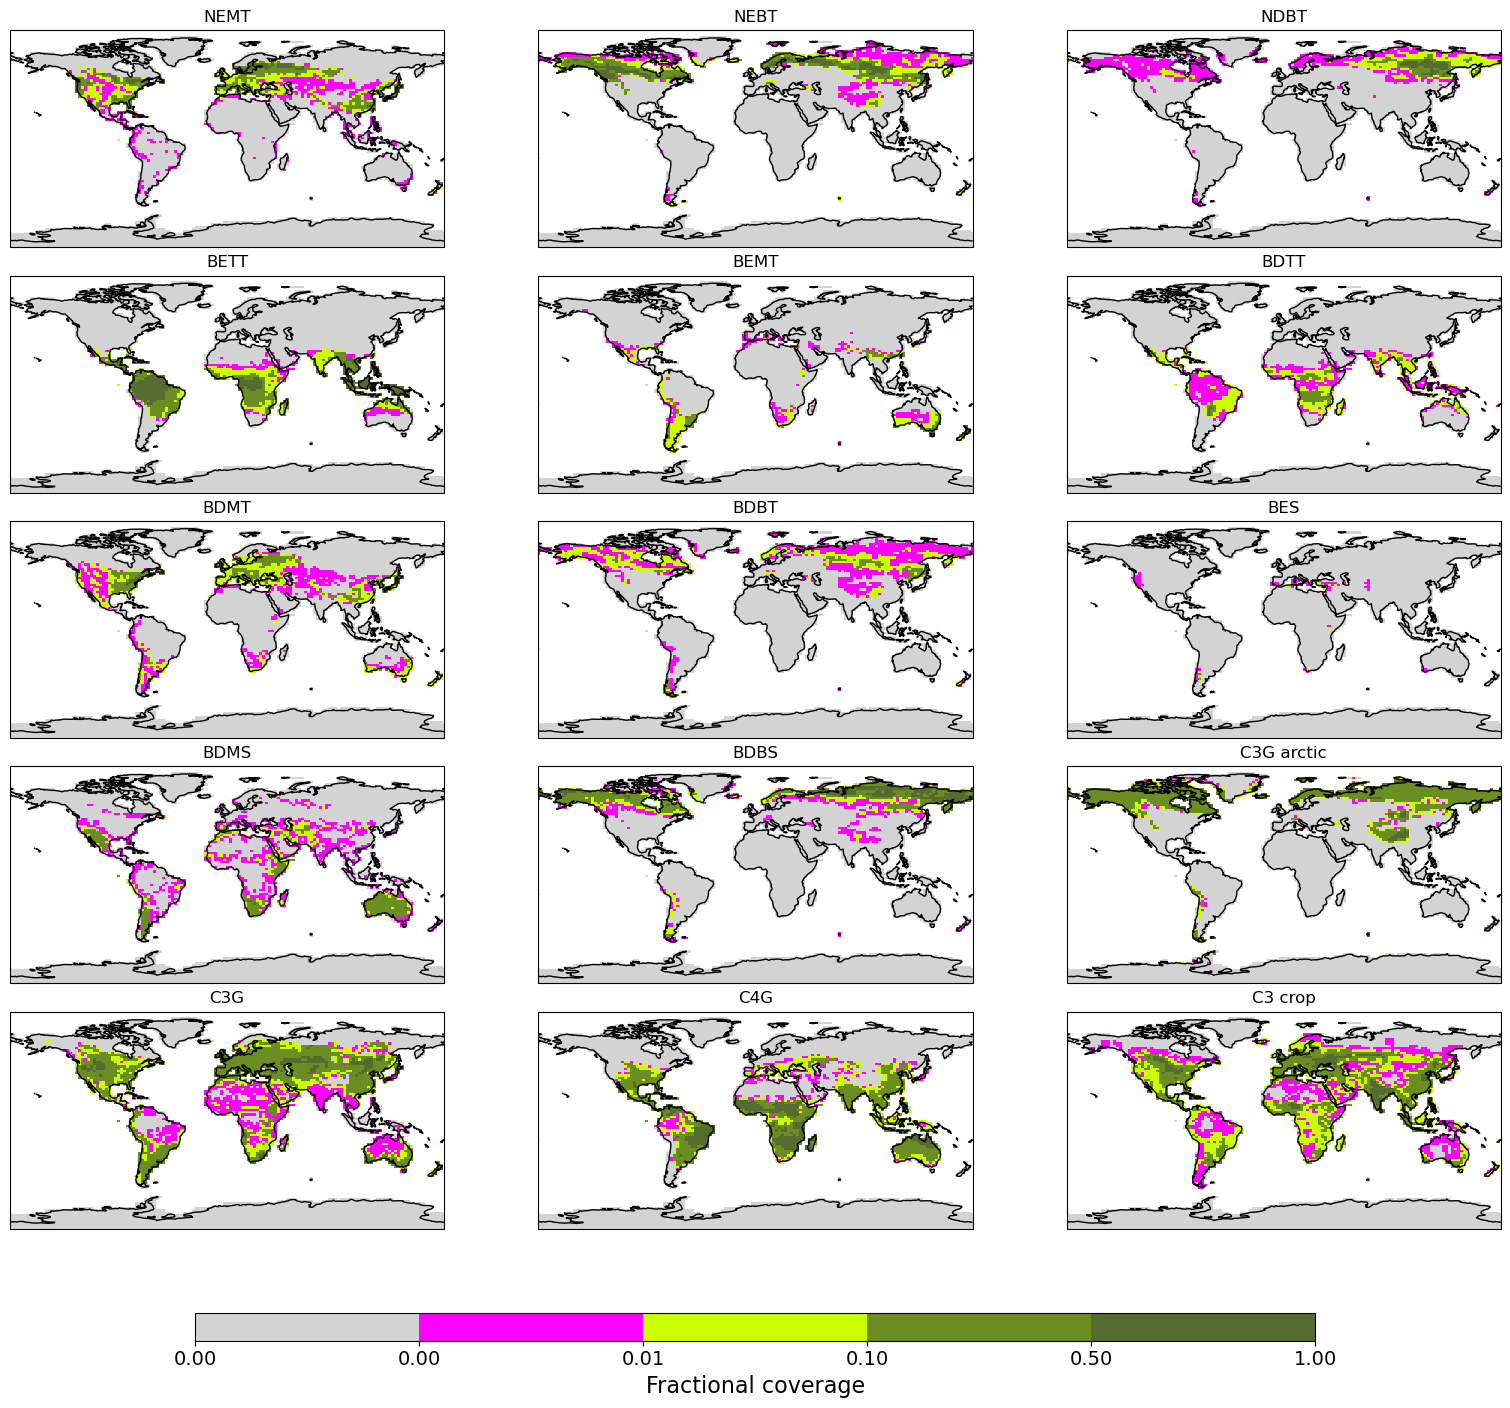

In [90]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
pft_names = ['not veg','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3G arctic','C3G','C4G','C3 crop']

# Define the number of rows and columns for subplots
nrows, ncols = 5, 3  # Adjusted for 15 PFTs (5 rows × 3 columns)

fig, axes = plt.subplots(nrows, ncols, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(16, 14))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for pft in range(15):  # Adjusted to use zero-based indexing
    da = pft_w_grid.sel(pft=pft+1)  # Assuming PFTs are indexed from 1 to 15
    
    ax = axes[pft]  # Select the correct subplot
    
    # Add coastlines and features
    ax.coastlines()
    #ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")

    # Plot the data
    p = ax.pcolormesh(ds_sp.lon, ds_sp.lat, da, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # Set subplot title
    ax.set_title(pft_names[pft+1])

# Adjust layout
plt.tight_layout()


# Adjust subplot layout to make space for the colorbar
fig.subplots_adjust(bottom=0.12)  # Move subplots up to make room below
cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # Adjust position: move up slightly
cbar = plt.colorbar(p, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Fractional coverage", fontsize=16)  # Larger font size
cbar.ax.tick_params(labelsize=14)  # Increase tick labels font size


plt.savefig("PFT_fractional_coverage_ctsm5.3_2003-2015.png", dpi=300, bbox_inches="tight")
